# Notebook do jednowymiarowej symulacji FDTD

Importowanie bibliotek

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np

Ustalamy stałe: $\epsilon_0$ i $\mu_0$. W celu weryfikacji obliczamy prędkość światła $c$.

In [2]:
epsilon0 = 625000/(22468879468420441*np.pi) 
mu0 = np.pi/2500000
c = 1/np.sqrt(epsilon0*mu0)
c

299792458.0

Definiiujemy parametry siatki: 
- długość przewodu $l$
- krok siatki $dx$
- krok czasowy $dt$

Na ich podstawie ustawiamy wielkość siatki: $nx$


In [3]:
l = 500 # m
dx = 1  #m
dt = 10e-10 # s
nx = int(l/dx)
nx

500

Sprawdzamy warunek zbieżności:
$$\frac{dx}{dt} > c $$"nie powinniśmy przeprowadzać obliczeń wolniej niż biegnie fala"


In [4]:
dx/dt > c

True

Alokacja siatki na $E_z$ oraz $H_y$, a także wartości $\sigma$

Implementuję tu PML (perfectly matched layer) - odpowiednie dopasowanie brzegów symuluje obszar nieograniczony.

<IPython.core.display.Javascript object>


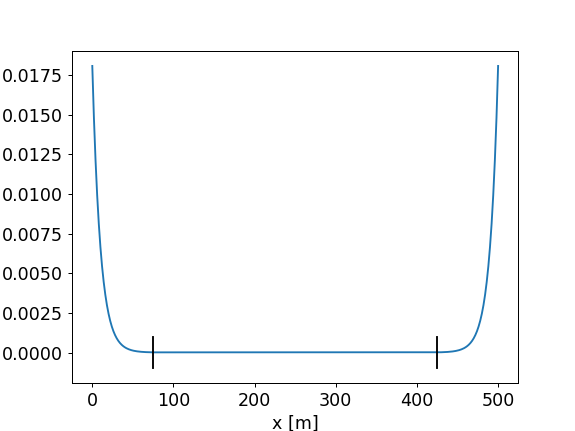

In [18]:
ez = np.zeros(nx)
hy = np.zeros(nx)

sigma = 0.00001 * np.ones(nx)


#L = 50
#for i in range(L):
#    sigma[i] = 1
#    sigma[nx-i-1] = 1

per = 0.15
L = int(per*nx)
for i in range(L):
    sigma[i] *= np.exp((L-i)/10)
    sigma[nx-i-1] *= np.exp((L-i)/10)

    
x = np.linspace(0, l, nx)
plt.plot(x,sigma)
plt.plot([(1-per)*l, (1-per)*l], [-100*min(sigma),100*min(sigma)], 'k-')
plt.plot([per*l, per*l], [-100*min(sigma), 100*min(sigma)], 'k-')
plt.ylabel('przewodniość $\sigma$ [1/($\Omega$m)]')
plt.xlabel('x [m]')
plt.show()

Usjalamy źródło w postaci sinusoidy jednostkowej

In [6]:
p = int(nx/2)

def current(time):
    p = int(nx/2)
    return p, 0.01*np.sin(2 * np.pi * (0 - 0.005 * time))

Zmienne pomocnicze usprawniające obliczenia (stałe w czasie współczynniki obliczamy raz, a nie za każdym razem)

In [7]:
coef_e_loss = [ (epsilon0 - sigma[i]*dt/2)/(epsilon0 + sigma[i]*dt/2) for i in range(nx) ]
coef_e_step = [ dt/(dx*(epsilon0 + sigma[i]*dt/2)) for i in range(nx) ]
coef_h_step = [ dt/(dx*mu0) for i in range(nx) ]
coef_j = [ dt/(epsilon0 + sigma[i]*dt/2) for i in range(nx) ]

Funkcje pomocnicze wykonujące kroki symulacji. Warunki brzegowe ustalamy jako zerowe pole.

In [8]:
#@jit(nopython=True)
def e_interior_update():
    for i in range(1,nx-1):
        ez[i] = coef_e_loss[i]*ez[i] + coef_e_step[i]*(hy[i]-hy[i-1])
        
#@jit(nopython=True)
def h_interior_update():
    for i in range(1,nx-1):
        hy[i] = hy[i] + coef_h_step[i]*(ez[i+1]-ez[i])
        
        
#@jit(nopython=True)
def e_current_apply(time):
    point, val = current(time)
    ez[point] = ez[point] - coef_j[point] * val
            

<IPython.core.display.Javascript object>


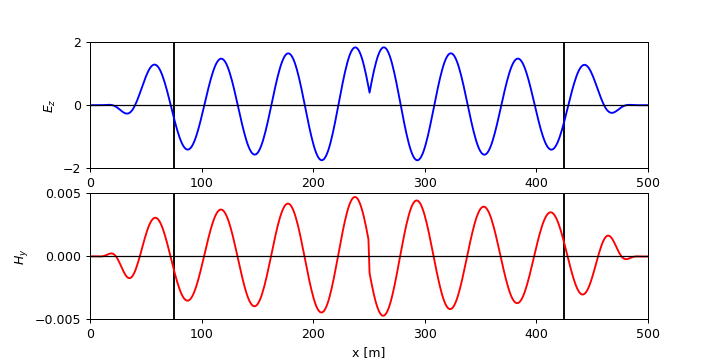

In [9]:
# create figure and axes 
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4))
ax1.plot([(1-per)*l, (1-per)*l], [-2, 2], 'k-')
ax1.plot([per*l, per*l], [-2, 2], 'k-')
ax2.plot([(1-per)*l, (1-per)*l], [-2, 2], 'k-')
ax2.plot([per*l, per*l], [-2, 2], 'k-')

ax1.set(xlabel='x [m]', ylabel='$E_z$')
ax2.set(xlabel='x [m]', ylabel='$H_y$')



# creating our line objects for the plots
ezplot, = ax1.plot(x, ez, '-b')
hyplot, = ax2.plot(x, hy, '-r')

def animate(t):
    """
    funkcja wywoływana przez animacje w celu obliczenia kolejnego kroku symulacji
    
    t: czas
    
    return:
        ezplot: ydata
        hyplot: ydata
    """
    
    for i in range(1):
        e_interior_update()
        #e_boundary_conditions()
        e_current_apply(t)

        h_interior_update()
        #h_boundary_conditions()
    
    ezplot.set_ydata(ez)
    hyplot.set_ydata(hy)


def init():
    """
    initialize the figure
    """
    
    ax1.set_ylim(-2, 2)
    ax2.set_ylim(-0.005, 0.005)

    ax1.set_xlim(0, l)
    ax2.set_xlim(0, l)
    ax1.axhline(0, color='black', lw=1)
    ax2.axhline(0, color='black', lw=1)
    plt.rcParams.update({'font.size':14})
    
    return ezplot, hyplot,

ani = FuncAnimation(fig, animate, init_func=init, interval=50, blit=True)
plt.show()